# Introduction to creating seismic synthetics
In this tutorial, we will create a simple geological model using GemPy, turn this into a 3D synthetic model of seismic wave velocities, then forward propagate a source through the model. We will then plot the synthetic shot gathers generated, and visualise the wavefield in 3D using PyVista.

The synthetics which we will be building in this tutorial will be made with the use of GemPy, an open-source 3D geological modelling package for python. As this is not a core dependency of Devito, we will need to install it. If issues are encountered whilst installing GemPy into a `conda` environment using `pip`, you can alternatively create a python `venv` and install Devito in this environment using `pip` as per usual. Note that it will also be necesary to install an `ipykernel` in this environment to run this notebook. From here, we can install GemPy:

In [1]:
# NBVAL_IGNORE_OUTPUT
try:
    # Import gempy
    import gempy as gp
except ModuleNotFoundError:
    # Need to install these
    ! pip install aiohttp==3.7.1
    ! pip install pyvista==0.29
    ! pip install pyqt5
    # Install gempy
    ! pip install gempy==2.2.9
    # Import gempy
    import gempy as gp
    
try:
    # Import jinja2 (used for colour coding geology)
    import jinja2
except ModuleNotFoundError:
    # Install jinja2
    ! pip install jinja2
    # Import jinja2
    import jinja2

No module named 'osgeo'


The simple geological model which we will be building is designed to evoke carbon-capture and storage (CCS) scenarios.

The model consists of a CO2 lens in a sandstone reservoir, with a shale layer in the overarching anticline providing the structural trap. This is then overlain by a layer of sediment, with water at the top of the model. Geological strata and their respective velocities are based on values detailed in [Queißer et al. 2013](https://doi.org/10.1190/geo2012-0216.1), a paper imaging the P-wave velocity anomaly generated by CO2 injection into the Utsira Sand at Sleipnir in the North Sea using FWI. The model we will create features a similar shale trap/permeable sandstone reservoir structure, albeit with a small number of thick layers rather than the thin interbedding, to limit model complexity for this tutorial. Further inspiration was taken from [Chadwick et al. 2004](https://doi.org/10.1016/j.energy.2004.03.071), a paper characterizing the Utsira Sand reservoir based on 2D seismic lines and well logs.


## Creating our geological model:

To begin, alongside GemPy, we need to import auxiliary modules:

In [2]:
# Import auxiliary modules
import numpy as np

%matplotlib inline

We will now set up a GemPy `Model` object. This encapsulates the grid onto which the scalar fields associated with various surfaces are interpolated. Note that the extent is slightly greater than it will be for our Devito model (an extra half a grid spacing is added to each side).

![gempy_devito_grid_diagram.png](https://github.com/devitocodes/devito/examples/seismic/tutorials/gempy_devito_grid_diagram.png?raw=1)
A comparison of the cell-centered vs node-centered conventions of GemPy and Devito respectively, along with the differences in how they measure extent. It is necessary to account for this to ensure that the two grids are co-located.

As we can see in the figure above, this is due to differences in the way in which grids are defined in each package and is necessary to ensure that the model is not stretched and distorted when transistioning between the two, and that they are correctly aligned.

In [3]:
# Set overarching model parameters
extent = (-5., 1005., -5., 1005., -1005., 5.)
shape = (101, 101, 101)

geo_model = gp.create_model('Gempy-tutorial')
geo_model = gp.init_data(geo_model, extent=extent, resolution=shape)

Active grids: ['regular']


Setting up Theano for our model (used by GemPy for interpolation). Bear in mind that that this may take some time to run.

In [4]:
# NBVAL_IGNORE_OUTPUT
gp.set_interpolator(geo_model, output=['geology'], theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                        values
range             1749.371316
$C_o$            72864.285714
drift equations           [3]


As the top CO2 surface is truncated by the upper shale layer, we will need to separate the geological strata into two GemPy `Series`. Each `Series` object, as the name suggests is intended to correspond with a geological unit, and they can be made to onlap, erode, etc one another. Whilst in practice, the top CO2 contact is not an erosive surface, treating it as such is the most straightforward way to create the desired truncation.

A default series is included in the model. As such, rather than creating a new series, we will simply rename it to 'Lower'. As you can imagine, this is going to be used to contain the lower geological units, these being the lower shale, reservoir sandstone, and CO2 lens.

In [5]:
geo_model.rename_series({'Default series': 'Lower'})

And now add our surfaces:

In [6]:
# NBVAL_IGNORE_OUTPUT
geo_model.add_surfaces(['co2', 'sands', 'lowershale'])

,surface,series,order_surfaces,color,id
0,co2,Lower,1,#015482,1
1,sands,Lower,2,#9f0052,2
2,lowershale,Lower,3,#ffbe00,3


We will now set some points for the base of the sands and CO2. The lower shale is considered the basement, meaning that its base does not need to be defined and it will extend to the bottom of the model. Alongside these points, we wil need to define an orientation for the surface.

To minimise repetition, we will define a function to loop over a list of points and add each to the surface.

In [7]:
def create_surface(model, points, surface):
    """Add a list of points to a surface in a model"""
    xyz = ('X', 'Y', 'Z')
    for point in points:
        kwargs = {**dict(zip(xyz, point)), 'surface': surface}
        model.add_surface_points(**kwargs)

# The points defining the base of the sand layer
sand_points = [(322, 135, -783), (635, 702, -791), (221, 668, -772), (732, 235, -801), (442, 454, -702)]

# Call our function
create_surface(geo_model, sand_points, 'sands')

# Add the surface orientation
geo_model.add_orientations(X=442., Y=495., Z=-752.,
                           surface='sands', pole_vector=(0.05, 0.05, 0.95))

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,442.0,495.0,-752.0,0.05,0.05,0.95,0.01,sands


We will now repeat this process for the CO2 lens.

In [8]:
# Points defining the base of the CO2 layer
co2_points = [(322, 135, -650), (635, 702, -650), (221, 668, -650), (732, 235, -650), (442, 454, -650)]

create_surface(geo_model, co2_points, 'co2')

# Add the surface orientation
geo_model.add_orientations(X=495., Y=495., Z=-650.,
                           surface='co2', pole_vector=(0., 0., 1.))

,X,Y,Z,G_x,G_y,G_z,smooth,surface
1,495.0,495.0,-650.0,0.00,0.00,1.00,0.01,co2
0,442.0,495.0,-752.0,0.05,0.05,0.95,0.01,sands


We will now add an upper series, containing statigraphy above the CO2 lens.

In [9]:
geo_model.add_series('Upper')

,order_series,BottomRelation,isActive,isFault,isFinite
Lower,1,Erosion,True,False,False
Upper,2,Erosion,False,False,False


As we can see, the upper series has been added below the lower series. This is not ideal for obvious reasons, and hence we will reorder them:

In [10]:
geo_model.reorder_series(['Upper', 'Lower'])

,order_series,BottomRelation,isActive,isFault,isFinite
Upper,1,Erosion,False,False,False
Lower,2,Erosion,True,False,False


And add our remaining surfaces:

In [11]:
# NBVAL_IGNORE_OUTPUT
geo_model.add_surfaces(['water', 'sediments', 'uppershale'])

,surface,series,order_surfaces,color,id
0,co2,Lower,1,#015482,1
1,sands,Lower,2,#9f0052,2
2,lowershale,Lower,3,#ffbe00,3
3,water,Lower,4,#728f02,4
4,sediments,Lower,5,#443988,5
5,uppershale,Lower,6,#ff3f20,6


As these surfaces are not mapped to the upper series by default, we shall do so:

In [12]:
# NBVAL_IGNORE_OUTPUT
gp.map_stack_to_surfaces(geo_model, {'Upper': ('water', 'sediments', 'uppershale')})

,surface,series,order_surfaces,color,id
3,water,Upper,1,#728f02,1
4,sediments,Upper,2,#443988,2
5,uppershale,Upper,3,#ff3f20,3
0,co2,Lower,1,#015482,4
1,sands,Lower,2,#9f0052,5
2,lowershale,Lower,3,#ffbe00,6


Now we will add the points for the upper series. Note that there is only a single orientation included. It is not necessary to define an orientation for each surface, so long as there is an orientation in the series.

In [13]:
# Surface points
uppershale_points = [(322, 135, -633), (635, 702, -641), (221, 668, -622), (732, 235, -651), (442, 454, -552)]
sediments_points = [(322, 135, -433), (635, 702, -441), (221, 668, -422), (732, 235, -451), (442, 454, -352)]
water_points = [(232, 153, -221), (653, 234, -216), (112, 872, -198), (532, 572, -223),
                (722, 884, -189), (632, 429, -201), (732, 348, -222)]

# Add the points to our surfaces
create_surface(geo_model, uppershale_points, 'uppershale')
create_surface(geo_model, sediments_points, 'sediments')
create_surface(geo_model, water_points, 'water')

# Set an orientation
geo_model.add_orientations(X=442., Y=495., Z=-502.,
                           surface='uppershale', pole_vector=(0.05, 0.05, 0.95))

,X,Y,Z,G_x,G_y,G_z,smooth,surface
2,442.0,495.0,-502.0,0.05,0.05,0.95,0.01,uppershale
1,495.0,495.0,-650.0,0.00,0.00,1.00,0.01,co2
0,442.0,495.0,-752.0,0.05,0.05,0.95,0.01,sands


Finally, we can add the p wave velocities associated with each of these layers. Note that any parameter can be set in this manner (density, elastic parameters, attenuation, etc) if desired for more complex synthetics.

In [14]:
# NBVAL_IGNORE_OUTPUT
geo_model.add_surface_values([1.5, 1.75, 2.5, 1.1, 2., 2.5], ['vp'])
geo_model.surfaces

,surface,series,order_surfaces,color,id,vp
3,water,Upper,1,#728f02,1,1.500000
4,sediments,Upper,2,#443988,2,1.750000
5,uppershale,Upper,3,#ff3f20,3,2.500000
0,co2,Lower,1,#015482,4,1.100000
1,sands,Lower,2,#9f0052,5,2.000000
2,lowershale,Lower,3,#ffbe00,6,2.500000


Now we can visualise our model, plotting data points and orientations. Then we must compute our model to interpolate the surfaces and any associated scalar fields. Then we can plot our surfaces and the associated units.

In [15]:
# NBVAL_IGNORE_OUTPUT
# Compute the model. Note that a solution is returned. We will use this later
sol = gp.compute_model(geo_model)

In [16]:
# NBVAL_SKIP
# Set up plotter
p3d = gp.plot_3d(geo_model, plotter_type='background', notebook=True)
# Plot data points and orientations
p3d.plot_data()

# Plot the surfaces
p3d.plot_surfaces()
# Plot the lithological units
p3d.plot_structured_grid('lith')

[StructuredGrid (0x7f26b9356e50)
   N Cells:	1000000
   N Points:	1030301
   X Bounds:	0.000e+00, 1.000e+03
   Y Bounds:	0.000e+00, 1.000e+03
   Z Bounds:	-1.000e+03, 0.000e+00
   Dimensions:	101, 101, 101
   N Arrays:	1,

## Bridging the gap from GemPy to Devito:

As you may have noticed, when we compute our GemPy model, a `Solution` object is returned. From this, we can extract the rasterized values attached to each of our geological units. With this in mind, we can print the solution values:

In [17]:
sol.values_matrix

array([[2.5       , 2.44720385, 2.        , ..., 1.5       , 1.5       ,
        1.5       ]])

You will notice that these values correspond with the p wave velocities we specified. However, they are in the form of 1D vector. Consequently, will need to reshape this array to fit into the `vp` parameter of a Devito `Model`. Note that you could do this with further parameters such as density or shear wave velocity for more complex models. In this case, you would want to set up a Devito `Function` to contain each parameter.

Note that in this case, we need to select c-like index order to get the axis in the correct order.

In [18]:
# Reshaping our data to the shape required by Devito
reshaped = np.reshape(sol.values_matrix, shape, order='C')
reshaped.shape

(101, 101, 101)

Now let us plot a slice through this model for quality checking purposes.

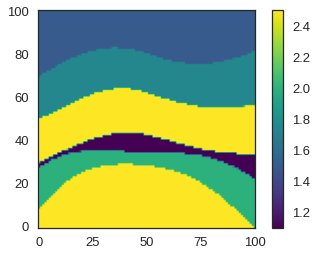

In [19]:
# NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt

# Take the center slice in the x direction
# Remember that in Devito, indexing convention is [x, y, z] (need to flip for correct imshow display)
plt.imshow(reshaped[50].T, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

## Seismic modelling with Devito

We can now start building our Devito model. The following draws heavily from the Devito `examples/sesimic/tutorials/01_modelling.ipynb` notebook. We will begin, as always with some imports.

In [20]:
import devito as dv
from examples.seismic import Model

As mentioned earlier, Devito and GemPy have slightly different grid implementations, so we need to tweak the Devito configuration slightly to make it map to the GemPy grid. We can now construct a Devito `Model`. This is a convenience object encapsulating the necessary parameters and components of an acoustic wave model, including additional damping layers around the perimeter (specified by `bcs="damp"`). For custom setups, see the `examples/userapi/04_boundary_conditions.ipynb`. Note that we are using a relatively large amount of damping layers here. This is to avoid our gathers becoming too messy, and ensure that reflections from horizons can be straightforwardly identified in the gathers.

In [21]:
# NBVAL_IGNORE_OUTPUT
seis_model = Model(vp=reshaped, origin=(0., 0., -1000.), spacing=(10., 10., 10.), shape=shape, nbl=30, space_order=4, bcs="damp")

Operator `initdamp` ran in 0.06 s
Operator `pad_vp` ran in 0.01 s


Now we will set up the time axis for our model. Again, this is a convenience object, which we will use in setting up the source and recievers.

In [22]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = seis_model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

We will position our source at a depth of 20m, and center it in all other axes.

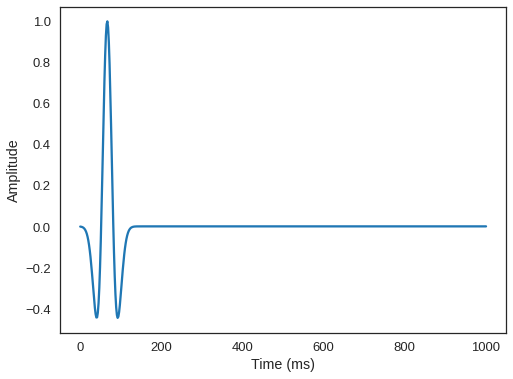

In [23]:
from examples.seismic import RickerSource

f0 = 0.015  # Source peak frequency is 15Hz (0.015 kHz)
src = RickerSource(name='src', grid=seis_model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[:] = np.array(seis_model.domain_size) * .5
src.coordinates.data[0, -1] = -20  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

We will also configure our recievers in a line along the x axis, centered in the y, also at a depth of 20m.

In [24]:
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=seis_model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, seis_model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 0.5*seis_model.domain_size[1]
rec.coordinates.data[:, -1] = -20.  # Depth is 20m

In Devito, equation parameters which vary in space only are represented using `Function` objects. If we also want them to vary over time, we must use a `TimeFunction`.

With this, we can define our partial differential equation.

In [25]:
# Define the wavefield with the size of the model and the time dimension
u = dv.TimeFunction(name="u", grid=seis_model.grid, time_order=2, space_order=4)

# We can now write the PDE
pde = seis_model.m * u.dt2 - u.laplace + seis_model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y, z)*Derivative(u(t, x, y, z), t) - Derivative(u(t, x, y, z), (x, 2)) - Derivative(u(t, x, y, z), (y, 2)) - Derivative(u(t, x, y, z), (z, 2)) + Derivative(u(t, x, y, z), (t, 2))/vp(x, y, z)**2

Now create our update stencil:

In [26]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions

stencil = dv.Eq(u.forward, dv.solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y, z), (-(-2.0*u(t, x, y, z)/dt**2 + u(t - dt, x, y, z)/dt**2)/vp(x, y, z)**2 + Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2)) + damp(x, y, z)*u(t, x, y, z)/dt)/(damp(x, y, z)/dt + 1/(dt**2*vp(x, y, z)**2)))

Now we can set up our source and reciever terms to include in our `Operator`.

In [27]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / seis_model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

Create our operator:

In [28]:
op = dv.Operator([stencil] + src_term + rec_term, subs=seis_model.spacing_map)

And run it.

In [29]:
# NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=seis_model.critical_dt)

Operator `Kernel` ran in 8.12 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=8.100275999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0007340000000000083, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.010583000000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

We can now plot our shot record using everyone's favourite colourmap. We can clearly see the reflected arrivals from the seabed, top shale, and top CO2. We can also distinguish the base of the CO2 lens and the interface between the reservoir sandstone and the underlying shale.

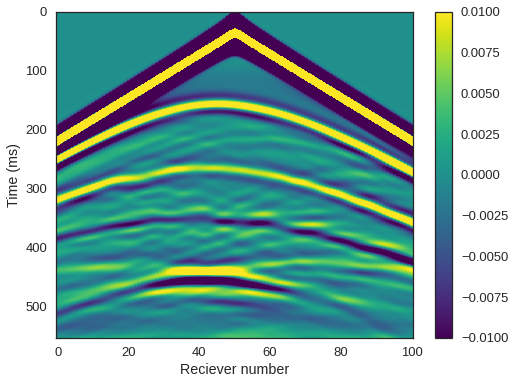

In [30]:
plt.imshow(rec.data, cmap='viridis', aspect='auto', vmax=0.01, vmin=-0.01)
plt.xlabel("Reciever number")
plt.ylabel("Time (ms)")
plt.colorbar()
plt.show()

## Visualisation with PyVista:
As PyVista is a dependency of GemPy, we can use its plotting capabilities to plot some slices to visualise our wavefield

In [31]:
import pyvista as pv

# Trim down the data from u to remove damping field
trimmed_data = u.data[1, 30:-30, 30:-30, 30:-30]

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(trimmed_data.shape) + 1

# Edit the spatial reference
grid.origin = (0., 0., -1000.)  # The bottom left corner of the data set
grid.spacing = (10, 10, 10)  # These are the cell sizes along each axis

We can now fill the grid cells:

In [32]:
# Add the data values to the cell data
grid.cell_arrays["values"] = trimmed_data.flatten(order="F")  # Flatten the array!

And plot!

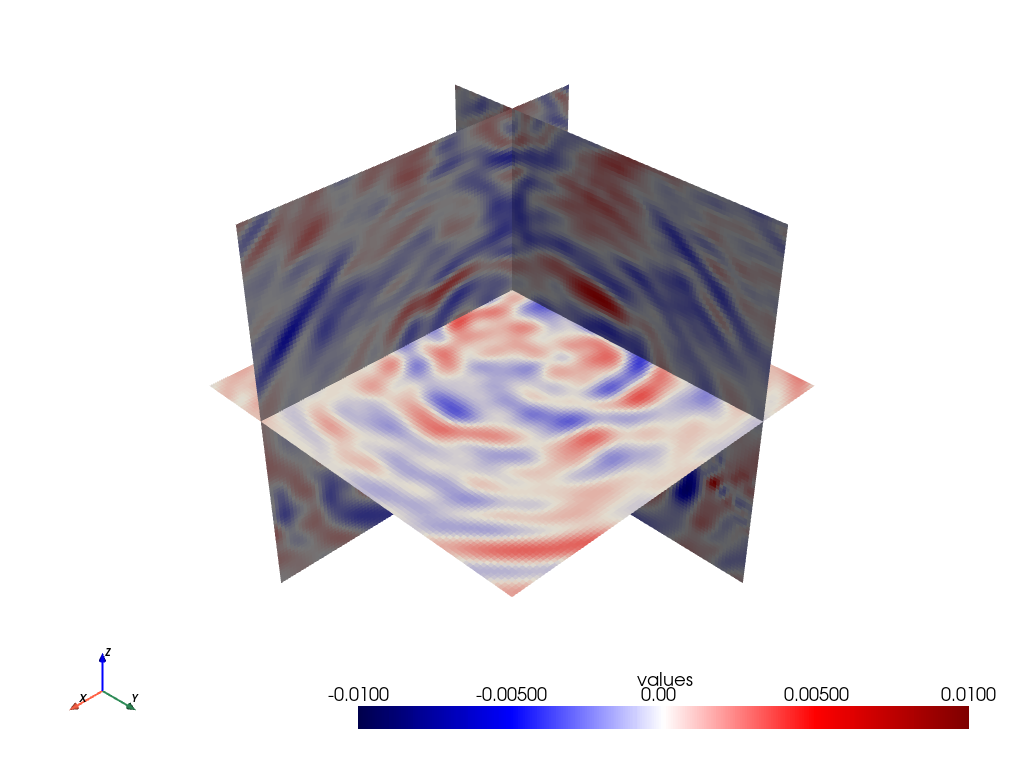

[(2456.1701691039184, 2456.1701691039184, 1456.1701691039184),
 (505.0, 505.0, -495.0),
 (0.0, 0.0, 1.0)]

In [33]:
# NBVAL_SKIP
orth_slices = grid.slice_orthogonal(x=200, y=200, z=-500)

orth_slices.plot(cmap='seismic', clim=[-0.01, 0.01])

Some other visualisation shenanigans:

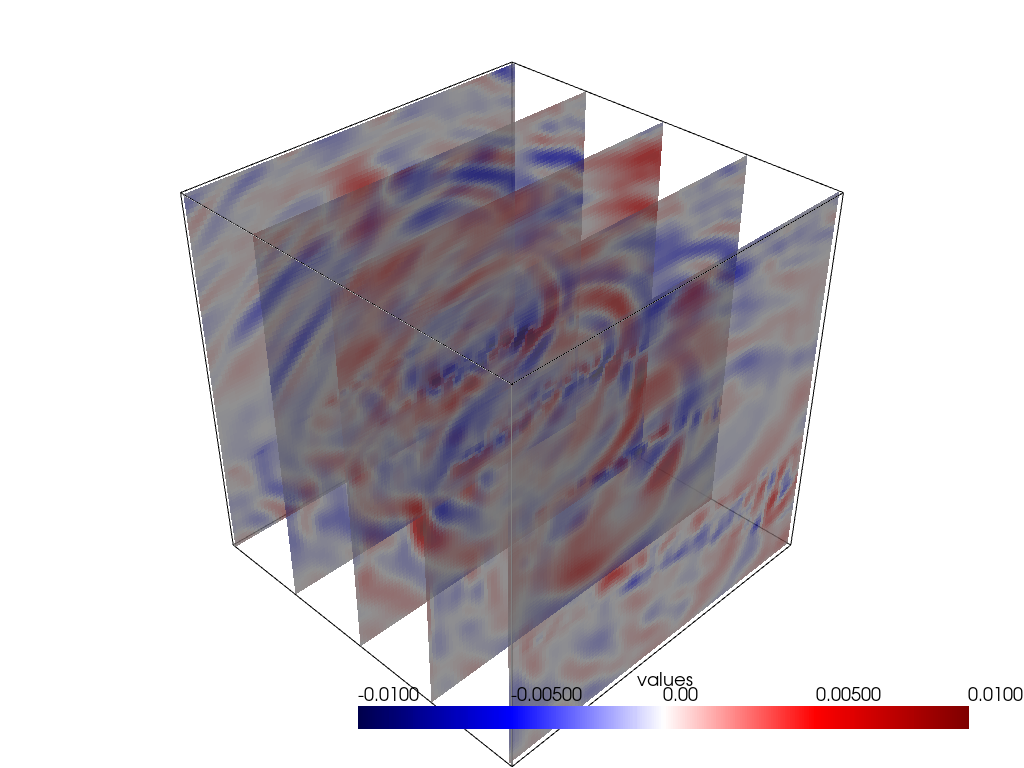

[(2456.1701691039184, 2456.1701691039184, 1456.1701691039184),
 (505.0, 505.0, -495.0),
 (0.0, 0.0, 1.0)]

In [34]:
# NBVAL_SKIP
y_slices = grid.slice_along_axis(n=5, axis="y")
p = pv.Plotter()
p.add_mesh(grid.outline(), color="k")
p.add_mesh(y_slices, cmap='seismic', clim=[-0.01, 0.01], opacity=0.8)
p.show()